#Colab Install Environment

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 742 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 29.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 11.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 32.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |

#Example

In [2]:
from torch_geometric.data import Data

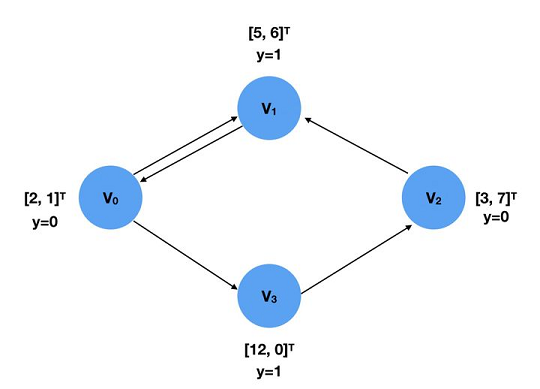

In [3]:
x = torch.tensor([[2,1],[5,6],[3,7],[12,0]], dtype=torch.float)

y = torch.tensor([0,1,0,1], dtype=torch.float)

edge_index = torch.tensor([[0,0,1,2,3],
              [1,3,0,1,2]],
              dtype=torch.long)

In [4]:
data = Data(x=x, y=y, edge_index=edge_index)

In [5]:
print(data)

Data(x=[4, 2], edge_index=[2, 5], y=[4])


#Basic operation

In [6]:
print(data.keys)

['x', 'y', 'edge_index']


In [7]:
print(data['x'])

tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])


In [8]:
for key, item in data:
  print(f'{key} found in data:\n{item}\n')

x found in data:
tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])

edge_index found in data:
tensor([[0, 0, 1, 2, 3],
        [1, 3, 0, 1, 2]])

y found in data:
tensor([0., 1., 0., 1.])



In [9]:
'edge_attr' in data

False

In [10]:
data.num_nodes

4

In [11]:
data.num_edges

5

In [12]:
data.num_node_features

2

In [13]:
data.has_isolated_nodes()

False

In [14]:
data.has_self_loops()

False

In [15]:
data.is_directed()

True

In [16]:
# Transfer data object to GPU.
data = data.cuda()

#Load Dataset

In [17]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


ENZYMES(600)

In [18]:
len(dataset)

600

In [19]:
dataset.num_classes

6

In [20]:
data = dataset[0]
data

Data(edge_index=[2, 168], x=[37, 3], y=[1])

In [21]:
train_dataset = dataset[:540]
train_dataset

ENZYMES(540)

In [22]:
test_dataset = dataset[540:]
test_dataset

ENZYMES(60)

#Data Shuffle

Method 1

In [23]:
dataset = dataset.shuffle()
dataset

ENZYMES(600)

Method 2

In [24]:
perm = torch.randperm(len(dataset))
dataset = dataset[perm]
dataset

ENZYMES(600)

#Data Transforms

In [25]:
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'])
dataset[0]

Extracting /tmp/ShapeNet/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1])

In [26]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='/tmp/ShapeNet/processed', categories=['Airplane'], pre_transform=T.KNNGraph(k=6))
dataset[0]

Extracting /tmp/ShapeNet/processed/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1], edge_index=[2, 15108])

#Build model and train

In [27]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset

Processing...
Done!


Cora()

In [28]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [29]:
model = GCN().cuda()
data = dataset[0].cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [30]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7990


#Exercises

###1. What does edge_index.t().contiguous() do?

In [35]:
edge_index_1 = torch.tensor([[0, 1, 1, 2],
               [1, 0, 2, 1]], dtype=torch.long)
print(edge_index_1, edge_index_1.shape)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]]) torch.Size([2, 4])


In [36]:
edge_index_2 = torch.tensor([[0, 1],
               [1, 0],
               [1, 2],
               [2, 1]], dtype=torch.long)
print(edge_index_2, edge_index_2.shape)

tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]]) torch.Size([4, 2])


In [39]:
edge_index_3 = edge_index_2.t().contiguous()
print(edge_index_3, edge_index_3.shape)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]]) torch.Size([2, 4])


In [43]:
edge_index_1 == edge_index_3

tensor([[True, True, True, True],
        [True, True, True, True]])

###2. Load the "IMDB-BINARY" dataset from the TUDataset benchmark suite and randomly split it into 80%/10%/10% training, validation and test graphs.

In [51]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
dataset

IMDB-BINARY(1000)

In [52]:
dataset = dataset.shuffle()

In [53]:
train_dataset = dataset[:800]
validation_dataset = dataset[800:900]
test_dataset = dataset[900:]

In [54]:
print(train_dataset, validation_dataset, test_dataset)

IMDB-BINARY(800) IMDB-BINARY(100) IMDB-BINARY(100)


###3. What does each number of the following output mean?

print(batch)<br>
\>>> DataBatch(batch=[1082], edge_index=[2, 4066], x=[1082, 21], y=[32])

My answer (not necessarily correct):<br>
batch=[1082] : Batch size = 1082 <br>
edge_index=[2, 4066] : Total of 4066 edges <br>
x=[1082, 21] : 1082 node and feature number is 21 <br>
y=[32] : Total of 32 targets